In [1]:
import sys
sys.path.append('../')

import numpy as np
from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v
from scipy import stats


import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.proj3d import proj_transform
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d


import scienceplots
from tensorflow.python.client import device_lib

#plt.rcParams['figure.figsize'] = [10,10]

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16

from tensorflow.nn import depthwise_conv2d
from tensorflow.math import multiply, reduce_sum, reduce_mean,reduce_euclidean_norm, sin, cos, abs
from tensorflow import stack, concat, expand_dims

import tensorflow_probability as tfp

from utils.utils import *
import cv2


from PIL import Image

from scipy import ndimage, fft

plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '100'})

2025-08-27 10:55:41.631526: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-27 10:55:41.641521: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756306541.653489   14461 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756306541.657679   14461 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756306541.667607   14461 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

#### Experiment #1 : Symmetric Convolution


I0000 00:00:1756306543.063731   14461 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1185 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


TensorShape([50, 50])

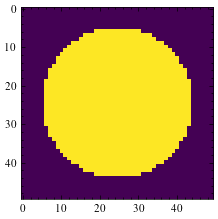

In [2]:
'''img = np.zeros((45, 45))
center_coordinates = (img.shape[0]//2, img.shape[1]//2) 
img = cv2.circle(img, center_coordinates, 20, (255,255,255), -1) 
plt.imshow(img)'''


N = 50
#img =  tf.image.rot90(tf.random.uniform(shape=(50,50,1), minval=0., maxval=1.), k=1) #
#img = tf.image.pad_to_bounding_box(img, 25//2,25//2,N+25, N+25)[...,0]

img =  tf.expand_dims(cv2.imread('input4.png', 0)/255. , axis=-1)
H, W, C = img.shape  # Get image dimensions
offset_height = (H - N) // 2
offset_width = (W - N) // 2
img = tf.image.crop_to_bounding_box(img, offset_height, offset_width, N, N)[...,0]
plt.imshow(img)
img.shape


(50, 50)


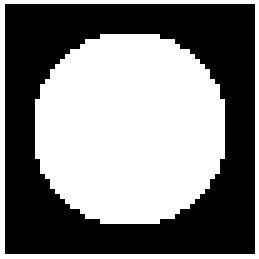

In [3]:
#var = 2/(128*9)

fig,ax = plt.subplots(1)

ax.imshow(img, cmap='gray')

#img = (img-np.mean(img))/np.std(img)
#img = tf.repeat(tf.expand_dims([img], axis=-1) , repeats = 512, axis=-1)  #get_double_slit(shape) , axis=0)
print(img.shape)
plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig("input.png",bbox_inches='tight',   pad_inches = 0)


Original shape: (500, 500)


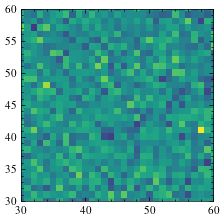

In [4]:
img = np.random.normal(loc=0.0, scale=1.0, size=(500, 500))
print("Original shape:", img.shape)

# Pad with 10 pixels of zeros on all sides
img = np.pad(img, pad_width=((10, 10), (10, 10)), mode='constant', constant_values=0)

fig, ax = plt.subplots()
ax.imshow(img)
x_min, x_max = 30, 60
y_min, y_max = 30, 60

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

plt.show()

tf.Tensor(1.0, shape=(), dtype=float64)
tf.Tensor(1.0079809766567136, shape=(), dtype=float64)
tf.Tensor(1.0310554356896178, shape=(), dtype=float64)
tf.Tensor(1.0668331551594492, shape=(), dtype=float64)
tf.Tensor(1.1119295239333962, shape=(), dtype=float64)
tf.Tensor(1.1625574447466513, shape=(), dtype=float64)
tf.Tensor(1.2149934329403305, shape=(), dtype=float64)
tf.Tensor(1.2658607087798388, shape=(), dtype=float64)
tf.Tensor(1.3122626666574368, shape=(), dtype=float64)
tf.Tensor(1.351824828508725, shape=(), dtype=float64)
tf.Tensor(1.3826924063995276, shape=(), dtype=float64)
tf.Tensor(1.4035121340383754, shape=(), dtype=float64)
tf.Tensor(1.4134128771475596, shape=(), dtype=float64)
tf.Tensor(1.411991304625562, shape=(), dtype=float64)
tf.Tensor(1.3993049091302563, shape=(), dtype=float64)
tf.Tensor(1.3758730128072842, shape=(), dtype=float64)
tf.Tensor(1.342685683087756, shape=(), dtype=float64)
tf.Tensor(1.301219644351623, shape=(), dtype=float64)
tf.Tensor(1.2534581840399155,

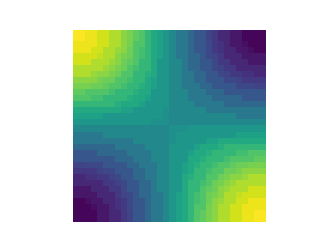

In [5]:

k = 32
w = np.zeros((k,k,1,1))


t1 = np.zeros((k,k))
t2 = np.zeros((k,k))
t3 = np.zeros((k,k))

'''t1[1, 2] = 1.
t2[2, 1] = 1.'''
t1[1,1] = 1.
t2[2, 0] = 1.
t3[0, 2] = 1.


w1 = fft.idctn(t1, norm='ortho')
#w1 /= np.sum(np.abs(w1))

w2 = fft.idctn(t2, norm='ortho') -  fft.idctn(t3, norm='ortho')
#w2 /= np.sum(np.abs(w2))

frames = []
angles = np.linspace(-np.pi, np.pi, 100)

angle0 = np.pi/8


for angle in angles :    
    
    fig, ax = plt.subplots()


    w[:,:,0,0] = (np.cos(2*angle))*w1 + ( np.sin(2*angle))*w2
    print(tf.math.reduce_euclidean_norm(w))
    w[:,:,0,0] = w[:,:,0,0] / (tf.math.reduce_euclidean_norm(w))


    im = ax.imshow(w[:,:,0,0], cmap=cm.viridis, animated=True)
    ax.axis("off")

    fig.canvas.draw()
    frame = np.array(fig.canvas.renderer.buffer_rgba())
    frames.append(Image.fromarray(frame))

    plt.close(fig)  # close to avoid showing each frame in notebook

frames[0].save("animation.gif", save_all=True, append_images=frames[1:], duration=100, loop=0)
from IPython.display import Image as IPyImage
IPyImage(filename="animation.gif")


In [6]:
w = np.zeros((3,3,1,1))


t1 = np.zeros((3,3))
t2 = np.zeros((3,3))
t3 = np.zeros((3,3))

'''t1[1, 2] = 1.
t2[2, 1] = 1.'''
t1[1,1] = 1.
t2[2, 0] = 1.
t3[0, 2] = 1.



w1 = fft.idctn(t1, norm='ortho')
#w1 /= np.sum(np.abs(w1))

w2 = fft.idctn(t2, norm='ortho') -  fft.idctn(t3, norm='ortho')
#w2 /= np.sum(np.abs(w2))



angle0 = 0

w[:,:,0,0] = (np.cos(2*angle0))*w1 + ( np.sin(2*angle0))*w2
print(tf.math.reduce_euclidean_norm(w))
w[:,:,0,0] = w[:,:,0,0] / (tf.math.reduce_euclidean_norm(w))


print(tf.math.reduce_euclidean_norm(w))
x = img

print("IMG", (tf.math.reduce_euclidean_norm(img)))





response_mag = []
init_mag = tf.math.reduce_euclidean_norm(x).numpy()



i0 = tf.cast(tf.repeat(tf.expand_dims([img], axis=-1) , repeats = w.shape[-2], axis=-1), dtype=tf.float32) 

print("I0,", tf.math.reduce_euclidean_norm(i0))


i1 = tf.nn.relu(tf.nn.conv2d(i0, w , strides=(1,1), padding='SAME') )

print("I1,", tf.math.reduce_euclidean_norm(i1))



init_mag = tf.math.reduce_euclidean_norm(i1).numpy()

angles = np.linspace(-np.pi, np.pi, 100)
for i in range(100):
	#fig, ax = plt.subplots()
	
	
	w[:,:,0,0] = (np.cos(2*angles[i]))*w1 + ( np.sin(2*angles[i]))*w2
	w[:,:,0,0] = w[:,:,0,0] / (tf.math.reduce_euclidean_norm(w))
		
	x_out = tf.nn.relu( tf.nn.conv2d(i1, w , strides=(1,1), 
								padding='SAME') )

	response_mag.append(tf.math.reduce_euclidean_norm(x_out).numpy()/init_mag)
	print(tf.math.reduce_euclidean_norm(x_out).numpy(), response_mag[-1])

tf.Tensor(1.0, shape=(), dtype=float64)
tf.Tensor(1.0, shape=(), dtype=float64)
IMG tf.Tensor(500.15345342427713, shape=(), dtype=float64)
I0, tf.Tensor(500.15344, shape=(), dtype=float32)


I0000 00:00:1756306545.388064   14461 cuda_dnn.cc:529] Loaded cuDNN version 91200


I1, tf.Tensor(354.06567, shape=(), dtype=float32)
278.0814 0.78539497
275.26566 0.7774424
267.68268 0.7560255
256.29114 0.723852
242.87923 0.6859723
229.04868 0.64691013
215.59142 0.60890234
203.42587 0.57454276
192.98265 0.54504764
184.55295 0.52123934
178.15752 0.50317645
173.98215 0.49138382
172.07553 0.4859989
172.39214 0.48689312
174.93431 0.49407306
179.68346 0.5074862
186.70001 0.52730334
195.71939 0.5527771
206.66956 0.583704
219.2914 0.61935234
232.91972 0.6578433
246.9304 0.69741416
259.9121 0.7340788
270.4314 0.7637888
276.9535 0.7822094
278.2026 0.7857373
273.9996 0.7738666
265.21106 0.74904484
253.15932 0.71500665
239.50089 0.6764307
225.53934 0.6369986
212.40388 0.5998997
200.60178 0.5665666
190.66748 0.5385088
182.78537 0.5162471
177.02052 0.49996522
173.4238 0.48980686
172.15086 0.4862117
173.06593 0.48879614
176.19307 0.4976282
181.44438 0.5124597
188.8857 0.5334765
198.36414 0.5602467
209.73311 0.5923565
222.5579 0.62857807
236.31802 0.6674412
250.06459 0.7062661
262.

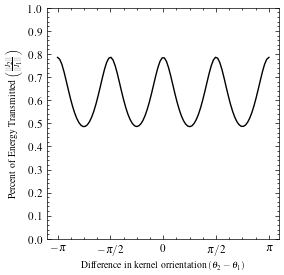

In [7]:
fig, ax= plt.subplots(1,1, figsize=(3,3))

ax.plot(angles,response_mag)

ticks = np.arange(-np.pi, 1.5*np.pi, np.pi/2)
labels = [r"$-\pi$", r"$-\pi/2$", r"$0$", r"$\pi/2$", r"$\pi$"]
# Set ticks and labels on the x-axis
ax.set_xticks(ticks=ticks, labels=labels);
ax.set_yticks(ticks=np.arange(0,1.1, 0.1));

ax.set_ylabel(r"Percent of Energy Transmitted $\left( \frac{||I_{2}||}{||I_{1}||} \right)$", fontsize=7)
ax.set_xlabel(r"Difference in kernel orrientation $(\theta_2 - \theta_1)$", fontsize=7)

plt.savefig('malus2_saddle.pdf', dpi=600)
plt.show()


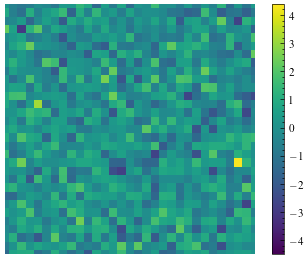

In [8]:
i0 = tf.cast(tf.repeat(tf.expand_dims([img], axis=-1) , repeats = w.shape[-2], axis=-1), dtype=tf.float32) 

fig, ax= plt.subplots(1,1)


im =ax.imshow(i0[0,...,0])
#ax.plot(45//2, 45, marker = '+', color='red');



ax.set(xlim=(0, img.shape[0]), ylim=(0,  img.shape[1]));

x_min, x_max = 30, 60
y_min, y_max = 30, 60

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

fig.colorbar(im, orientation='vertical');

plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig("i0_high_order.pdf",bbox_inches='tight',   pad_inches = 0, dpi=600)


tf.Tensor(500.15344, shape=(), dtype=float32)


<tf.Tensor: shape=(), dtype=float32, numpy=354.065673828125>

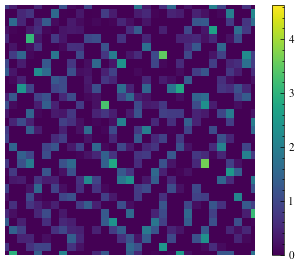

In [9]:
angle = -np.pi

w = np.zeros((3,3,1,1))

w[:,:,0,0] = (np.cos(2*angle))*w1 + ( np.sin(2*angle))*w2
w[:,:,0,0] = w[:,:,0,0] / (tf.math.reduce_euclidean_norm(w))


i0 = tf.cast(tf.repeat(tf.expand_dims([img], axis=-1) , repeats = w.shape[-2], axis=-1), dtype=tf.float32) 

print((tf.math.reduce_euclidean_norm(i0)))

i1_x = tf.nn.relu( tf.nn.conv2d(i0, w , strides=(1,1), 
							 padding='SAME') )


fig, ax= plt.subplots(1,1)

im =ax.imshow(i1[0,...,0])
#ax.plot(45//2, 45, marker = '+', color='red');




ax.set(xlim=(0, img.shape[0]), ylim=(0,  img.shape[1]));
x_min, x_max = 30, 60
y_min, y_max = 30, 60

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

fig.colorbar(im, orientation='vertical');

plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig("i1_high_order.pdf",bbox_inches='tight',   pad_inches = 0, dpi=600)
tf.math.reduce_euclidean_norm(i1)



<tf.Tensor: shape=(), dtype=float32, numpy=278.0813903808594>

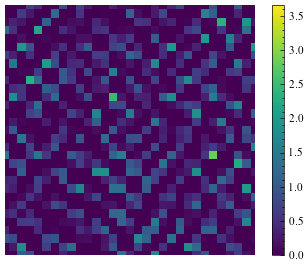

In [10]:
angle = -np.pi

w[:,:,0,0] = (np.cos(2*angle))*w1 + ( np.sin(2*angle))*w2
w[:,:,0,0] = w[:,:,0,0] / (tf.math.reduce_euclidean_norm(w))




i2_x = tf.nn.relu( tf.nn.conv2d(i1, w , strides=(1,1), 
							 padding='SAME') )


fig, ax= plt.subplots(1,1)

im =ax.imshow(i2_x[0,...,0])
#ax.plot(45//2, 45, marker = '+', color='red');



ax.set(xlim=(0, img.shape[0]), ylim=(0,  img.shape[1]));
x_min, x_max = 30, 60
y_min, y_max = 30, 60

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)


fig.colorbar(im, orientation='vertical');

plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig("i2_y_high_order.pdf",bbox_inches='tight',   pad_inches = 0, dpi=600)
tf.math.reduce_euclidean_norm(i2_x)

<tf.Tensor: shape=(), dtype=float32, numpy=278.38690185546875>

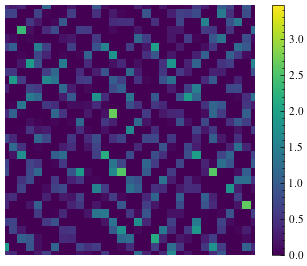

In [11]:
angle = np.pi/2

w[:,:,0,0] = (np.cos(2*angle))*w1 + ( np.sin(2*angle))*w2
w[:,:,0,0] = w[:,:,0,0] / (tf.math.reduce_euclidean_norm(w))




i2_y = tf.nn.relu( tf.nn.conv2d(i1, w , strides=(1,1), 
							 padding='SAME') )


fig, ax= plt.subplots(1,1)

im =ax.imshow(i2_y[0,...,0])
#ax.plot(45//2, 45, marker = '+', color='red');



ax.set(xlim=(0, img.shape[0]), ylim=(0,  img.shape[1]));
x_min, x_max = 30, 60
y_min, y_max = 30, 60

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)


fig.colorbar(im, orientation='vertical');

plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
#plt.savefig("i2_y_high_order.pdf",bbox_inches='tight',   pad_inches = 0, dpi=600)
tf.math.reduce_euclidean_norm(i2_y)

In [12]:
i0.shape

TensorShape([1, 520, 520, 1])

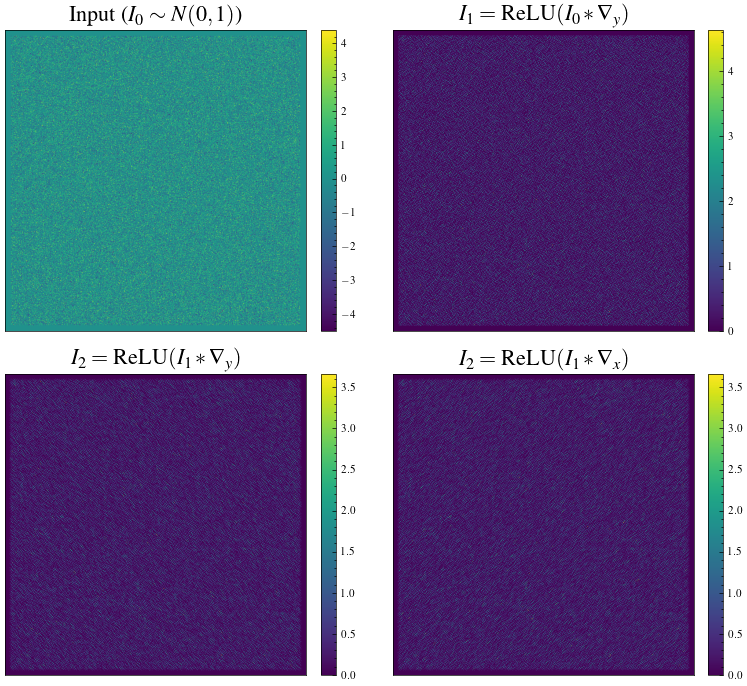

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(8, 7))
title_fontsize = 16  # Adjust as needed

# Top-left
im0 = axs[0, 0].imshow(i0[0,...,0].numpy(), cmap='viridis')
axs[0, 0].set_title(r'Input ($I_0 \sim N(0, 1)$)', fontsize=title_fontsize)
fig.colorbar(im0, ax=axs[0, 0], fraction=0.046, pad=0.04)
#ax.set(xlim=(0, img.shape[0]), ylim=(0,  img.shape[1]));



#fig.colorbar(im, orientation='vertical');


# Top-right
im1 = axs[0, 1].imshow(i1_x[0,...,0].numpy(), cmap='viridis')
axs[0, 1].set_title(r'$I_1 = \mathrm{ReLU}(I_0 * \nabla_y)$', fontsize=title_fontsize)
fig.colorbar(im1, ax=axs[0, 1], fraction=0.046, pad=0.04)

# Bottom-left
im2 = axs[1, 0].imshow(i2_x[0,...,0].numpy(), cmap='viridis')
axs[1, 0].set_title(r'$I_2 = \mathrm{ReLU}(I_1 * \nabla_y)$', fontsize=title_fontsize)
fig.colorbar(im2, ax=axs[1, 0], fraction=0.046, pad=0.04)

vmin = i2_x[0,...,0].numpy().min()
vmax = i2_x[0,...,0].numpy().max()


# Bottom-right
im3 = axs[1, 1].imshow(
    i2_y[0,...,0].numpy(), 
    cmap='viridis', 
    vmin=vmin, 
    vmax=vmax
)
axs[1, 1].set_title(r'$I_2 = \mathrm{ReLU}(I_1 * \nabla_x)$', fontsize=title_fontsize)
fig.colorbar(im2, ax=axs[1, 1], fraction=0.046, pad=0.04)

# Optional: tighten layout and remove axis ticks
for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.savefig("malus_saddle_circle.pdf", dpi=600)

plt.show()




In [14]:
np.max(i1_x), np.max(i2_x)

(np.float32(4.6364746), np.float32(3.6640625))

In [15]:
np.sum(w)

np.float64(0.0)

In [16]:
np.max(tf.nn.conv2d(i0, w , strides=(1,1), padding='SAME'))

np.float32(4.3754883)

In [17]:
np.max(tf.nn.conv2d(i1, w , strides=(1,1), padding='SAME'))

np.float32(3.4736328)

AttributeError: 'FigureCanvasAgg' object has no attribute 'tostring_rgb'

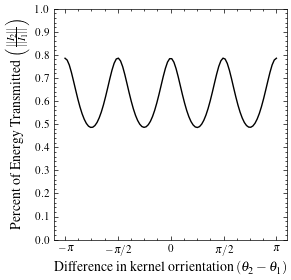

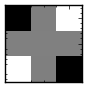

In [18]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox, TextArea, VPacker
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

def render_patch_with_border(patch, border_color='black', border_width=1, zoom=1.0):
	"""
	Renders a patch using imshow-style with a border and returns it as an OffsetImage.
	"""
	# Create a tiny figure to render the patch using imshow
	fig, ax = plt.subplots(figsize=(1, 1), dpi=100)
	canvas = FigureCanvas(fig)

	ax.imshow(patch, cmap='gray', interpolation='none')
	ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)


	for spine in ax.spines.values():
		spine.set_visible(True)
		spine.set_linewidth(1)
		spine.set_color('black')

	# Make sure spines are drawn on top of the image
	ax.set_frame_on(True)
	# Add rectangle border
	'''h, w = patch.shape
	ax.add_patch(plt.Rectangle(
		(-0.5, -0.5), w, h,
		edgecolor=border_color,
		facecolor='none',
		linewidth=border_width
	))'''

	# Render to array
	canvas.draw()
	img = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
	img = img.reshape(canvas.get_width_height()[::-1] + (3,))

	plt.close(fig)
	return OffsetImage(img, zoom=zoom)

# Function to place image on the curve

def add_patch_with_label(ax, x, y, patch, label):
	# Create rendered image with border
	imagebox = render_patch_with_border(patch, border_color='black', border_width=2, zoom=0.2)

	# Create label
	textbox = TextArea(label, textprops={
		'fontsize': 7,
		'ha': 'center',
		'va': 'center',
		'bbox': dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.1')
	})

	# Stack vertically
	vpack = VPacker(children=[textbox, imagebox], align="center", pad=0, sep=3)
	ab = AnnotationBbox(vpack, (x, y), frameon=False, box_alignment=(0.5, 0.5))

	ax.add_artist(ab)


fig, ax= plt.subplots(1,1, figsize=(3,3))

ax.plot(angles,response_mag)

ticks = np.arange(-np.pi, 1.5*np.pi, np.pi/2)
labels = [r"$-\pi$", r"$-\pi/2$", r"$0$", r"$\pi/2$", r"$\pi$"]
# Set ticks and labels on the x-axis
ax.set_xticks(ticks=ticks, labels=labels);
ax.set_yticks(ticks=np.arange(0,1.1, 0.1));

ax.set_ylabel(r"Percent of Energy Transmitted $\left( \frac{||I_{2}||}{||I_{1}||} \right)$", fontsize=10)
ax.set_xlabel(r"Difference in kernel orrientation $(\theta_2 - \theta_1)$", fontsize=10)

# Locations along curve
x1, y1 = -np.pi/2, response_mag[len(response_mag)//4]  # for dy
x2, y2 = np.pi, response_mag[-1]     # for dx
w[:,:,0,0] = (np.cos(np.pi))*w1 + ( np.sin(np.pi))*w2
dx_kernel = w[:,:,0,0]
dy_kernel = dx_kernel.T



add_patch_with_label(ax, x1,  y1-0.09, dy_kernel, r'$I_2 = \mathrm{ReLU}(I_1 * \nabla_x\nabla_y^2)$')
add_patch_with_label(ax, x2+0.05, y2+0.1, dx_kernel, r'$I_2 = \mathrm{ReLU}(I_1 * \nabla_y\nabla_x^2)$')


plt.savefig('malus_curve_circle_high_order.pdf', dpi=600)
plt.show()


In [ ]:
a = np.pi
w[:,:,0,0] = (np.cos(a))*w1 + ( np.sin(a))*w2

print((tf.math.reduce_euclidean_norm(w)))

w[:,:,0,0] = w[:,:,0,0] / (tf.math.reduce_euclidean_norm(w))
print((tf.math.reduce_euclidean_norm(w)))



tf.Tensor(1.0, shape=(), dtype=float64)
tf.Tensor(1.0, shape=(), dtype=float64)


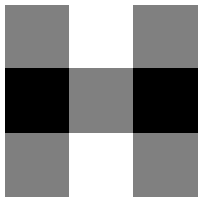

In [ ]:
w[:,:,0,0] = (np.cos(np.pi/2))*w1 + ( np.sin(np.pi/2))*w2





p = plt.imshow(w[:,:,0,0], cmap='gray')
plt.axis('off')
p


array([[[[ 0.13608276]],

        [[ 0.        ]],

        [[-0.13608276]]],


       [[[ 0.13608276]],

        [[ 0.        ]],

        [[-0.13608276]]],


       [[[ 0.13608276]],

        [[ 0.        ]],

        [[-0.13608276]]]])

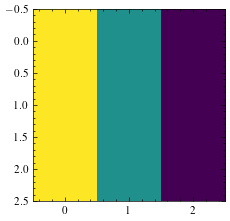

In [ ]:
a = np.zeros((3,3))
a[0, 1] =1
a = np.reshape(fft.idctn(a, norm='ortho'), (3,3,1,1))

b = np.zeros((3,3))
b[0, 0] =1
b = np.reshape(fft.idctn(b, norm='ortho'), (3,3,1,1))

dct_basis = a*b

plt.imshow(dct_basis[..., 0,0])
dct_basis